# Implementation of Genetic Algorithms using DEAP

## - Exercise 1:  One Max Problem

Write a Python program that optimizes the OneMax Problem through a canonical genetic algorithm and plots the best fitness against the number of generations.

Rember: 
1) OneMax Problem consists of maximizing the number of ones in a bit string: $ f(x) = \sum_{i=0}^{n-1} x_i $

2)  Consider the OneMax Problem with the following dimensions (i.e., the length of the bit string): n = 10, 20, 50.


In [1]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools

Firstly, let us create the classes Fitness and Individual by using DEAP Creator

In [2]:
#Creating Classes
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

Then, let's implement the setup of our genetic algorithm by defining the operators we want to use in the DEAP toolbox

In [3]:
IND_SIZE = 10
TOURN_SIZE = 3

toolbox = base.Toolbox()
toolbox.register('attr_float', lambda: random.randint(0,1))
#individuals
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE) 
#population
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

#Operators
#Crossover
toolbox.register('mate', tools.cxTwoPoint)
#Mutation
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
#Selection
toolbox.register('select', tools.selTournament, tournsize=TOURN_SIZE)
toolbox.register('select_r', tools.selRoulette)

Finally, let us define the fitness function of the one max problem. Moreover in the following cell it is created also the statistic container of DEAP

In [ ]:
#Evaluate function
def evaluate(individual):
    return sum(individual) #ONEMAX PROBLEM
toolbox.register('evaluate', evaluate)

#Statistical Features
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)


Now we have all the tools for writing down the main code of our genetic algorithm.

In [ ]:
def GA(POP_SIZE, CXPB, MUTPB, NGEN, stats):
    #Defininf Hall of Fame
    hof = tools.HallOfFame(1)
    
    #Creating the population
    pop = toolbox.population(n=POP_SIZE)
    print(pop)

    #Defining the Logbook
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else[])

    #Evaluate the entire population
    fitness = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitness):
        ind.fitness.values = [fit]


    hof.update(pop) if stats else {}

    record = stats.compile(pop) if stats else {}
    logbook.record(gen=0, nevals=len(pop), **record)
    

    for g in range(NGEN):
        print('Generation Number ', g, 'Population ', pop)
        #Select the next generation individuals
        offspring = toolbox.select_r(pop, len(pop))
        #Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        #Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2],offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        #Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitness = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitness):
            ind.fitness.values = [fit]

        if hof is not None:
            hof.update(offspring)
            print(hof)

        #The population in entirely replaced by the offspring
        pop[:] = offspring


        record = stats.compile(pop) if stats else{}
        print(record)
        logbook.record(gen=g+1, nevals=len(invalid_ind), **record)
        

    return pop, logbook

By running the following cell the Genetic Algorithm will be executed with the parameters passed in the GA function.

In [ ]:
GA_exe = GA(POP_SIZE=10,CXPB=0.8,MUTPB=0.1,NGEN=40, stats=stats)


Let's have a look on our loogbok:

In [ ]:
GA_exe[1]

Now, we can plot the value of the maximum fitness versus the number of generations of our algorithm

In [ ]:
import matplotlib.pyplot as plt
max_values = [GA_exe[1][i]['max'] for i in range(len(GA_exe[1]))]
ngen = [i for i in range(len(GA_exe[1]))]

fig = plt.plot(ngen, max_values)
plt.show()

As you can see, the best solution at each generation can be not selected and therefore the fitness function over the number of generations can also decrese.

We can implement the same genetic algorithm by adding the elitism operator in our survival selection mechanism. 

In [ ]:
def GA_with_elitism(POP_SIZE, CXPB, MUTPB, NGEN, stats):
    #Defininf Hall of Fame
    hof = tools.HallOfFame(1)
    
    #Creating the population
    pop = toolbox.population(n=POP_SIZE)
    print(pop)

    #Defining the Logbook
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else[])

    #Evaluate the entire population
    fitness = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitness):
        ind.fitness.values = [fit]


    hof.update(pop) if stats else {}

    record = stats.compile(pop) if stats else {}
    logbook.record(gen=0, nevals=len(pop), **record)
    

    for g in range(NGEN):
        print('Generation Number ', g, 'Population ', pop)
        
        #Select the next generation individuals
        offspring = toolbox.select_r(pop, len(pop))
        #Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        #Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2],offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        #Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitness = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitness):
            ind.fitness.values = [fit]

        if hof is not None:
            hof.update(offspring)
            print(hof)

        #The population in entirely replaced by the offspring
        pop[:] = tools.selBest(offspring, POP_SIZE-1)
        pop.append(hof[0])


        record = stats.compile(pop) if stats else{}
        print(record)
        logbook.record(gen=g+1, nevals=len(invalid_ind), **record)
        

    return pop, logbook

In [ ]:
GA_exe_elit = GA_with_elitism(POP_SIZE=10,CXPB=0.8,MUTPB=0.1,NGEN=40, stats=stats)



Let us see now, how the plot of max_fitness vs number of generation appears. 

In [ ]:
max_values = [GA_exe_elit[1][i]['max'] for i in range(len(GA_exe_elit[1]))]
ngen = [i for i in range(len(GA_exe_elit[1]))]

fig = plt.plot(ngen, max_values)
plt.show()

### Try it yourself: 

#### 1) Can you improve this algorithm changing the operators and performing the parameters tuning ?

#### 2) Test the algorithm with the different values of n.

_____

## - Exercise 2:  Sphere Problem

Write a Python program that optimizes the Sphere Problem through a genetic algorithm and plots the best fitness against the number of generations.

$$ f(\mathbf{x}) = f(x_1, x_2, \ldots, x_n) = \sum_{i=0}^{n-1} x_i^2$$

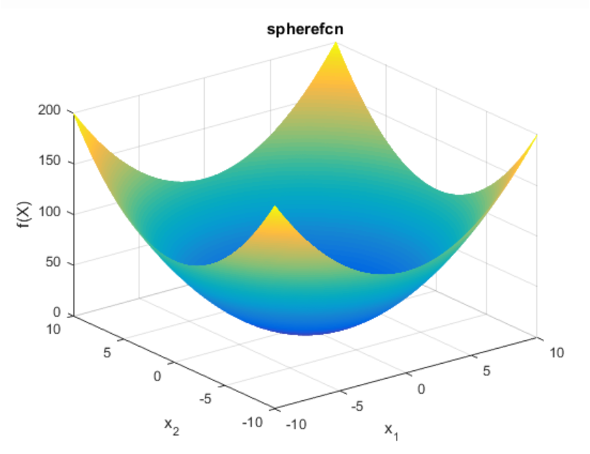

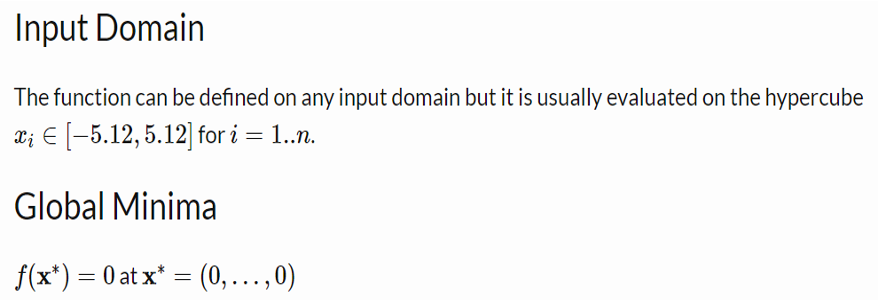

#### Try it yourself: 
 - Test your algorithm in the following dimensions $n  \in \{5,10, 20 \}$
 - Perform 15 runs for each problem dimension
 - Plots best fitness against the number of generations (a run for each problem dimension)
 - Display bar plot where each bar represents the average fitness value (mean on the 15 runs) for each problem dimension


____

### - Exercise 3: Griewank Problem 

Write a Python program that optimizes the Griewank Problem through two evolutionary algorithms: a genetic algorithm and the differential evolution.

$$ f(\mathbf{x}) = f(x_1, x_2, \ldots, x_n) = 1 + \sum_{i=0}^{n-1} \frac{x_i^2}{4000} - \prod_{i=0}^{n-1} cos\left(\frac{x_i}{\sqrt{i}}\right)$$

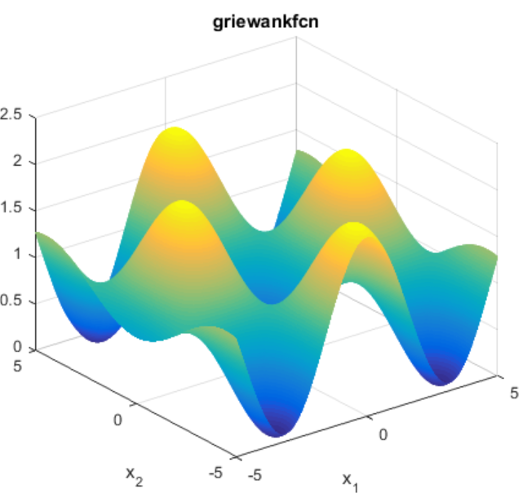

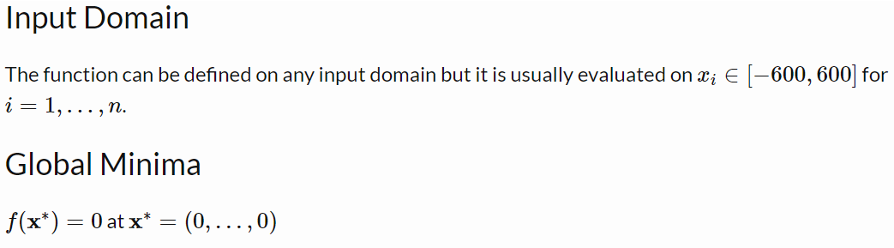

#### Try it yourself: 
 - Test your algorithm in the following dimension n=10
 - Perform 15 runs 
 - Use as Termination criterion: the number of evaluations in the following configuration $n_ev \in \{200, 500, 1000 \}$

 - Display a bar plot where each bar represents the average fitness value (mean on the 15 runs) for termination criterion

